Ciclo Crisis 52-55 ignorado (fuera de rango)
Ciclo Expansión 56-69 ignorado (fuera de rango)


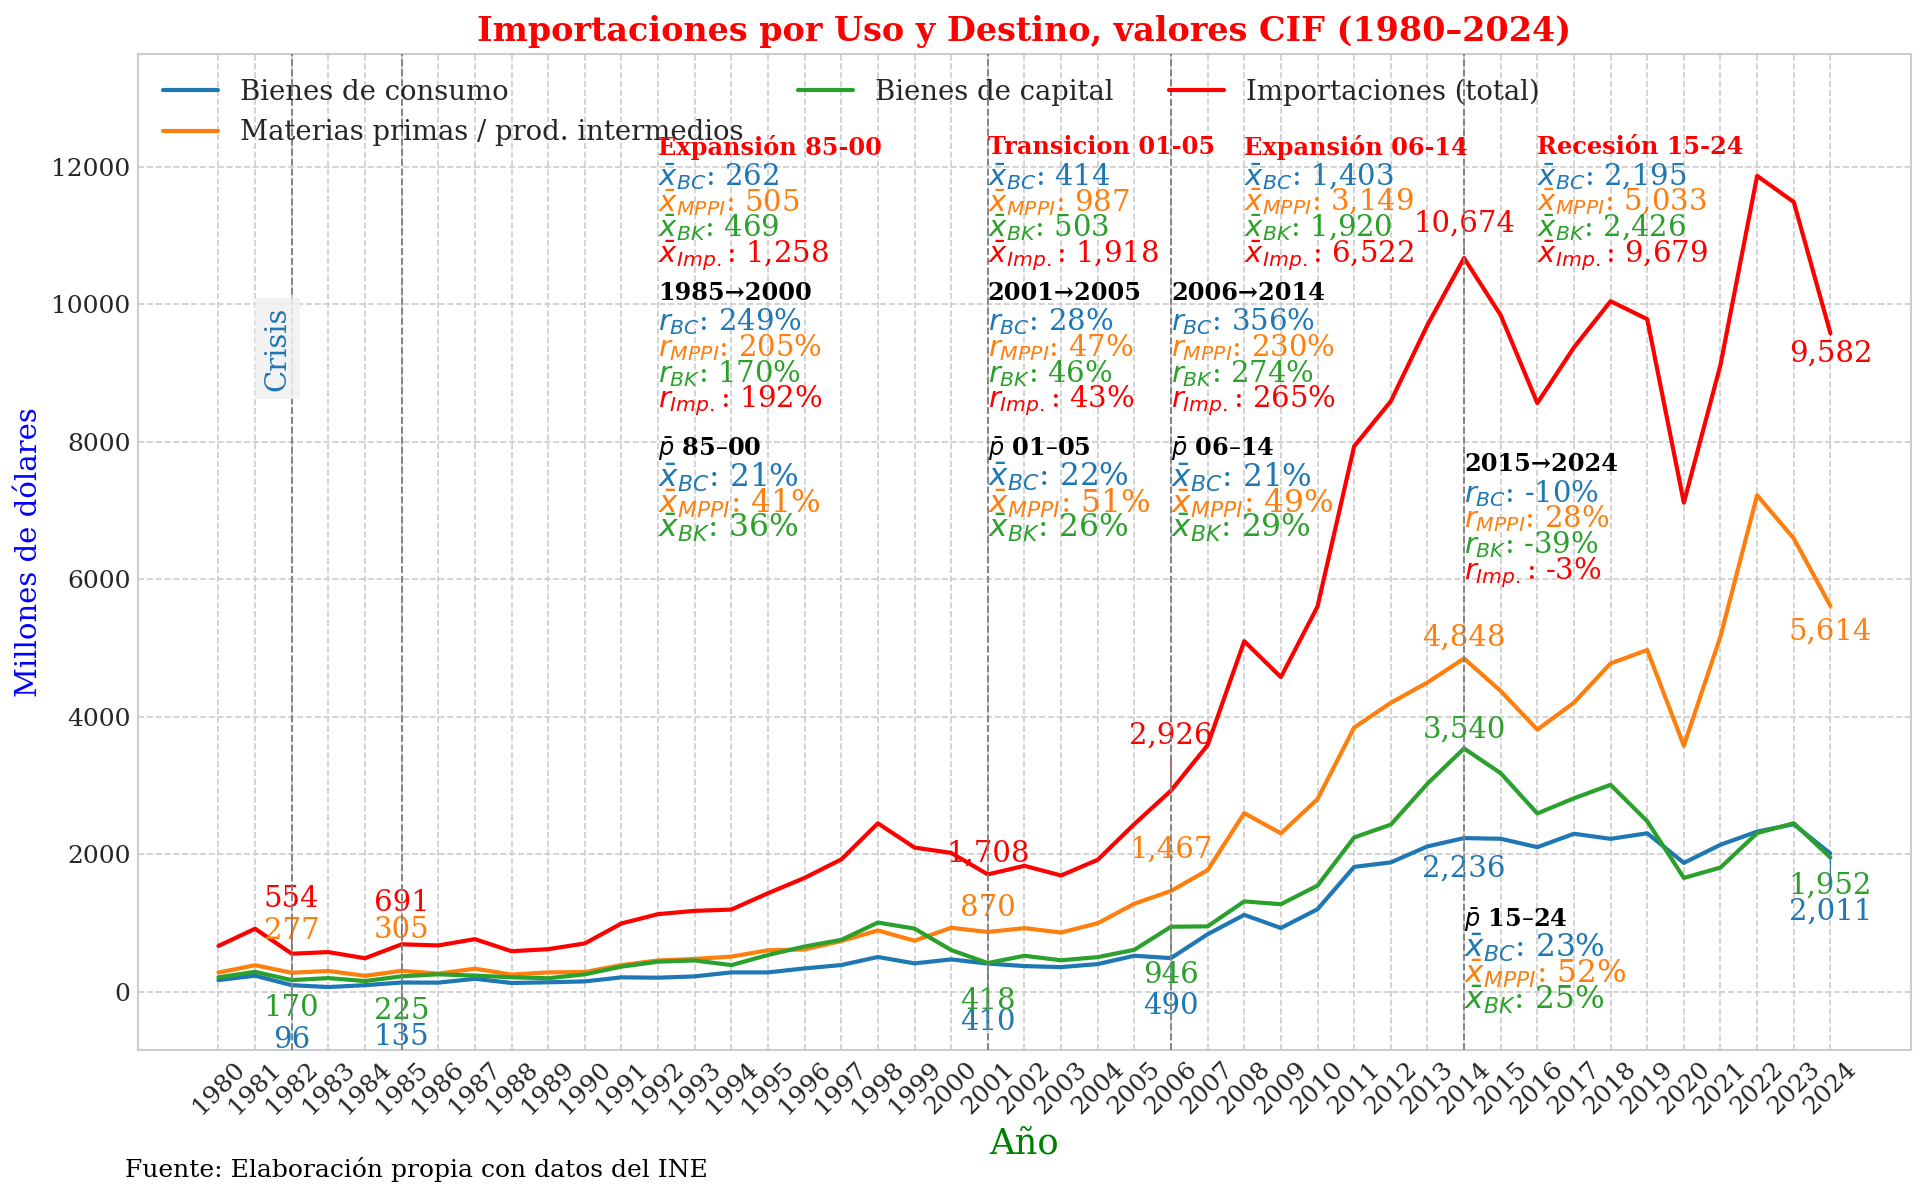

In [17]:
# ─────────────────────────────────────────────────────────────────────
# Importaciones
# ─────────────────────────────────────────────────────────────────────
import sys, os, sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('../'))  # utilidades propias
from graficos_utils import *
from config import *
# ─────────────────────────────────────────────────────────────────────
# Configuración general
# ─────────────────────────────────────────────────────────────────────
output_dir = "../../../../assets/tesis/serie_completa/importaciones"
os.makedirs(output_dir, exist_ok=True)
set_style()

# Carga de datos
with sqlite3.connect('../../../../db/proyectomacro.db') as conn:
    df = (pd.read_sql('SELECT * FROM composicion_importaciones_uso_destino', conn)
            .set_index('año')
            .sort_index())
    df.rename(columns={'total_valor_oficial_cif': 'importaciones'}, inplace=True)

# Componentes y columnas
componentes = [
    ('bienes_consumo', 'Bienes de consumo'),
    ('materias_primas_productos_intermedios', 'Materias primas / prod. intermedios'),
    ('bienes_capital', 'Bienes de capital'),
    ('importaciones', 'Importaciones (total)'),
]
cols_componentes = [col for col, _ in componentes]

# Abreviaturas
abbr_map = {
    'bienes_consumo': 'BC',
    'materias_primas_productos_intermedios': 'MPPI',
    'bienes_capital': 'BK',
    'importaciones': 'Imp.'
}

# ─────────────────────────────────────────────────────────────────────
# Preparación
# ─────────────────────────────────────────────────────────────────────
annotate_years    = adjust_annot_years(df, annot_years)
CYCLES            = adjust_cycles(df, CYCLES)
cycle_stats       = {name: df.loc[period, cols_componentes].mean().to_dict()
                     for name, period in CYCLES.items()}
periodos          = adjust_periods(df, periodos_tasas)
custom_colors     = {
    'bienes_consumo': '#1f77b4',
    'materias_primas_productos_intermedios': '#ff7f0e',
    'bienes_capital': '#2ca02c',
    'importaciones': 'red',
}

# ─────────────────────────────────────────────────────────────────────
# Offsets
# ─────────────────────────────────────────────────────────────────────
annotation_offsets = {
    'bienes_consumo': {
        1982: (0,   -800),
        1985: (0,   -800),   # antes 1986 → 1985 según annot_years
        2001: (0,   -850),   # antes 2000 → 2001
        2006: (0,   -700),
        2014: (0,   -450),
        2024: (0,   -850),   # antes 2024 → 2023
    },
    'materias_primas_productos_intermedios': {
        1982: (0,    600),
        1985: (0,    600),
        2001: (0,    350),
        2006: (0,    600),
        2014: (0,    300),
        2024: (0,   -380),
    },
    'bienes_capital': {
        1982: (0,   -400),
        1985: (0,   -500),
        2001: (0,   -550),
        2006: (0,   -700),
        2014: (0,    280),
        2024: (0,   -400),
    },
    'importaciones': {
        1982: (0,    800),
        1985: (0,    600),
        2001: (0,    300),
        2006: (0,    800),
        2014: (0,    500),
        2024: (0,   -300),
    },
}

# 2) Hitos verticales (usa exactamente las claves de hitos_v)
hitos_offset = {a: 0.8 for a in hitos_v}  # keys: 1952,1956,1970,1982,1985,2001,2006,2014 :contentReference[oaicite:0]{index=0}

# 3) Posición de medias por ciclo (claves según CYCLES)
medias_offsets = {
    "Expansión 56-69":    (1962, 1),
    "Recesión 70-81":     (1975, 1),
    "Expansión 85-00":    (1992, 1),   # antes "Expansión 86-99"
    "Transicion 01-05": (2001, 1),   # antes "Transición 00-05"
    "Expansión 06-14":    (2008, 1),   # antes "Expansión 06-13"
    "Recesión 15-24":     (2016, 1),   # antes "Recesión 14-24"
}

# 4) Tasas de crecimiento anotadas por periodo (claves según periodos_tasas)
tasas_offsets = {
    "1956-1969": (1963, 0.83),
    "1970-1981": (1976, 0.83),
    "1985-2000": (1992, 0.83),  # reemplaza "1986-2000"
    "2001-2005": (2001, 0.83),  # reemplaza "2000-2005"
    "2006-2014": (2006, 0.83),
    "2015-2024": (2014, 0.63),  # reemplaza "2014-2024"
}

# 5) Desplazamientos de cajas de participación por periodo
participation_offsets = {
    "1956-1969": (1963, 0.65),
    "1970-1981": (1976, 0.65),
    "1985-2000": (1992, 0.65),  # antes "1986-2000"
    "2001-2005": (2001, 0.65),  # antes "2000-2005"
    "2006-2014": (2006, 0.65),
    "2015-2024": (2014, 0.10),  # antes "2014-2024"
}

# ─────────────────────────────────────────────────────────────────────
# Gráfica
# ─────────────────────────────────────────────────────────────────────
fig, ax = init_base_plot(
    df,
    componentes,
    custom_colors,
    "Importaciones por Uso y Destino, valores CIF (1980–2024)",
    "Año",
    "Millones de dólares",
    source_text="Fuente: Elaboración propia con datos del INE"
)

add_hitos(
    ax, df.index, hitos_v, hitos_offset,
    line_kwargs={'linewidth': 0.9}
)
y_max = ax.get_ylim()[1]
line_spacing = y_max * 0.03
add_cycle_means_multi(
    ax, cycle_stats, medias_offsets,
    abbr_map, custom_colors,
    line_spacing
)

add_year_value_annotations(
    ax, df, annotate_years,
    cols_componentes, annotation_offsets,
    custom_colors, arrow_lw=0.5
)

add_period_growth_annotations_multi(
    ax, df, periodos,
    cols_componentes, tasas_offsets,
    custom_colors, abbr_map
)

add_participation_cycle_boxes(
    ax, df, periodos,
    ['bienes_consumo', 'materias_primas_productos_intermedios', 'bienes_capital'],
    'importaciones', participation_offsets,
    abbr_map=abbr_map, colors=custom_colors
)

ax.set_ylim(-850, df[cols_componentes].max().max() * 1.15)

plt.savefig(os.path.join(output_dir, "importaciones_uso_destino_valores.png"))
plt.show()


Ciclo Expansión 56-69 ignorado (fuera de rango)


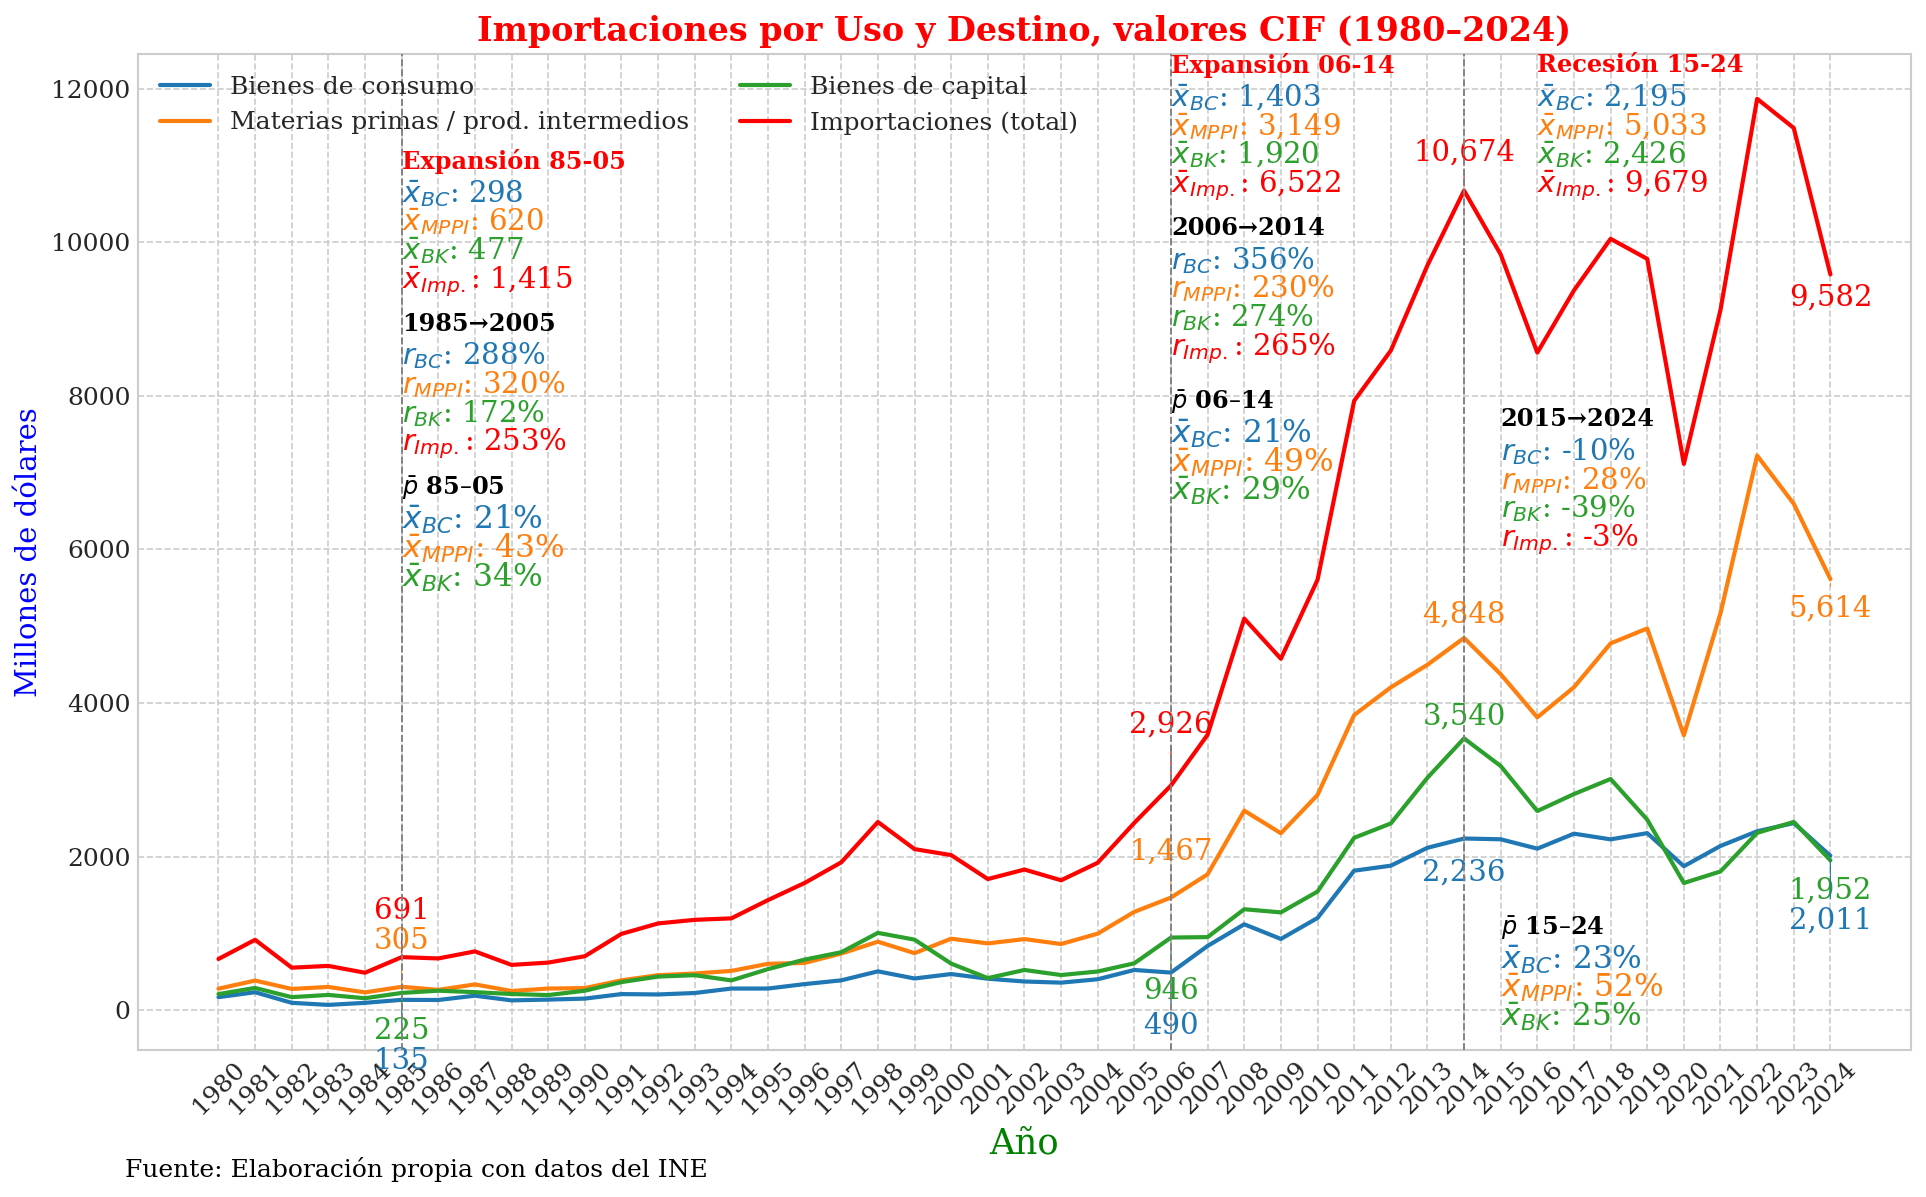

In [32]:
# ─────────────────────────────────────────────────────────────────────
# Preparación “sin crisis”
# ─────────────────────────────────────────────────────────────────────
# 1) Años para anotaciones sin crisis
annotate_years_sin_crisis = adjust_annot_years(df, annot_years_sin_crisis)

# 2) Ciclos sin crisis
CYCLES_SC                = adjust_cycles(df, CYCLES_SIN_CRISIS)
cycles_stats_sin_crisis  = {
    name: df.loc[period, cols_componentes].mean().to_dict()
    for name, period in CYCLES_SC.items()
}

# 3) Periodos para tasas sin crisis
periodos_sin_crisis      = adjust_periods(df, periodos_tasas_sin_crisis)


# ─────────────────────────────────────────────────────────────────────
# Offsets “sin crisis”
# ─────────────────────────────────────────────────────────────────────
# Desplazamientos (dx, dy) para anotaciones año-valor
#    years = annot_years_sin_crisis = [1950, 1970, 1985, 2006, 2014, 2022]
annotation_offsets_sin_crisis = {
    'bienes_consumo': {
        1950: (0,  -800),
        1970: (0,  -800),   # was 1971 → now 1970
        1985: (0,  -800),
        2006: (0,  -700),   # was 2005 → now 2006
        2014: (0,  -450),   # was 2015 → now 2014
        2024: (0,  -850),
    },
    'materias_primas_productos_intermedios': {
        1950: (0,   600),
        1970: (0,   600),
        1985: (0,   600),
        2006: (0,   600),
        2014: (0,   300),
        2024: (0,  -380),
    },
    'bienes_capital': {
        1950: (0,  -400),
        1970: (0,  -500),
        1985: (0,  -500),
        2006: (0,  -700),
        2014: (0,   280),
        2024: (0,  -400),
    },
    'importaciones': {
        1950: (0,   800),
        1970: (0,   600),
        1985: (0,   600),
        2006: (0,   800),
        2014: (0,   500),
        2024: (0,  -300),
    },
}

# 2) Hitos verticales (sin crisis)
#    keys = hitos_v_sin_crisis = {1956, 1970, 1985, 2006, 2014}
hitos_offset_sin_crisis = {
    1956: 0.8,
    1970: 0.8,
    1985: 0.8,
    2006: 0.8,
    2014: 0.8,
}

# 3) Cuadros de medias por ciclo
#    keys = CYCLES_SIN_CRISIS.keys()
medias_offsets_sin_crisis = {
    'Expansión 85-05': (1985, 0.9),
    'Expansión 06-14': (2006, 1),
    'Recesión 15-24':  (2016, 1),
}

# 4) Tasas de crecimiento por periodo
#    keys = ["1956-1969", "1970-1984", "1985-2005", "2006-2014", "2015-2022"]
tasas_offsets_sin_crisis = {
    '1985-2005': (1985, 0.73),
    '2006-2014': (2006, 0.83),
    '2015-2024': (2015, 0.63),
}

# 5) Cajas de participación por periodo
#    same keys as tasas_offsets_sin_crisis
participation_offsets_sin_crisis = {
    '1985-2005': (1985, 0.56),
    '2006-2014': (2006, 0.65),
    '2015-2024': (2015, 0.10),
}


# ─────────────────────────────────────────────────────────────────────
# Gráfica “sin crisis”
# ─────────────────────────────────────────────────────────────────────
fig, ax = init_base_plot(
    df,
    componentes,
    custom_colors,
    "Importaciones por Uso y Destino, valores CIF (1980–2024)",
    "Año",
    "Millones de dólares",
    source_text="Fuente: Elaboración propia con datos del INE",
    legend_fontsize=12,
    legend_ncol=2
)

add_hitos(
    ax, df.index, hitos_v_sin_crisis, hitos_offset_sin_crisis,
    line_kwargs={'linewidth': 0.9}
)
add_cycle_means_multi(
    ax,
    cycles_stats_sin_crisis, medias_offsets_sin_crisis,
    abbr_map, custom_colors,
    line_spacing=ax.get_ylim()[1] * 0.03
)
add_year_value_annotations(
    ax,
    df,
    annotate_years_sin_crisis,
    cols_componentes,
    annotation_offsets_sin_crisis,
    custom_colors,
    arrow_lw=0.5
)

add_period_growth_annotations_multi(
    ax,
    df,
    periodos_sin_crisis,
    cols_componentes,
    tasas_offsets_sin_crisis,
    custom_colors,
    abbr_map
)

add_participation_cycle_boxes(
    ax,
    df,
    periodos_sin_crisis,
    ['bienes_consumo', 'materias_primas_productos_intermedios', 'bienes_capital'],
    'importaciones',
    participation_offsets_sin_crisis,
    abbr_map=abbr_map,
    colors=custom_colors
)

plt.savefig(os.path.join(output_dir, "importaciones_sin_crisis.png"))
plt.show()


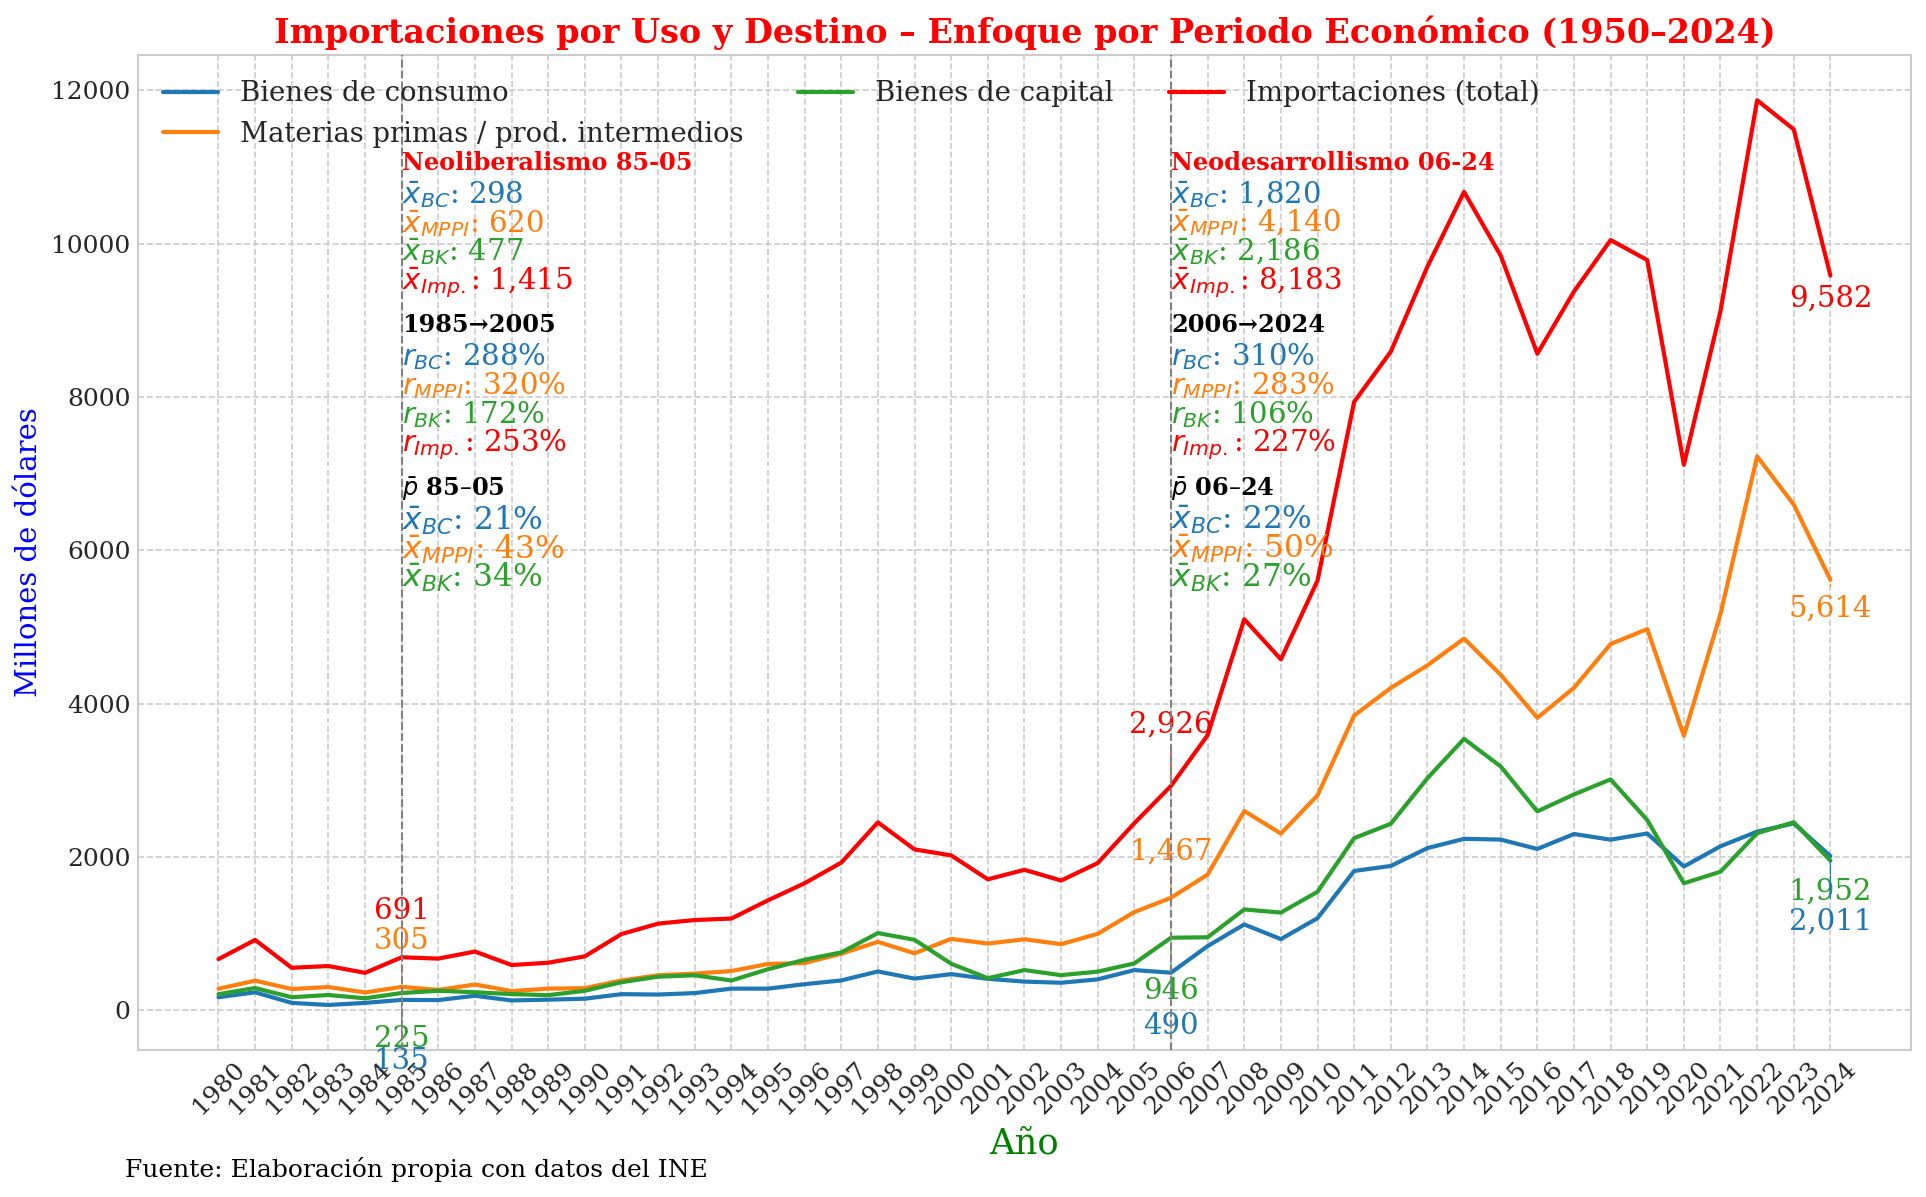

In [40]:
# ─────────────────────────────────────────────────────────────────────
# Preparación
# ─────────────────────────────────────────────────────────────────────
# 1) Años anotados
annotate_years_periodos = adjust_annot_years(df, annot_years_periodos)

# 2) Ciclos → ahora usamos los “periodos” estructurales
CYCLES_PERIODOS     = adjust_cycles(df, CYCLES_PERIODOS)
cycle_stats_periodos  = {nom: df.loc[sli, cols_componentes].mean().to_dict()
                for nom, sli in CYCLES_PERIODOS.items()}

# 3) Periodos para tasas
periodos_periodos = adjust_periods(df, periodos_tasas_periodos)

# ─────────────────────────────────────────────────────────────────────
# Offsets (ejemplo de punto de partida)
# ─────────────────────────────────────────────────────────────────────
# se reutilizan muchos offsets, pero ajustamos la clave según año-rango
# 1) Anotaciones de valores por rama y año (períodos estructurales)
annotation_offsets_periodos = {
    'bienes_consumo': {
        1950: (0, -800),
        1985: (0, -800),
        2006: (0, -700),
        2024: (0, -850),  # antes 2024 → ahora 2022
    },
    'materias_primas_productos_intermedios': {
        1950: (0, 600),
        1985: (0, 600),
        2006: (0, 600),
        2024: (0, -380),  # antes 2024 → ahora 2022
    },
    'bienes_capital': {
        1950: (0, -400),
        1985: (0, -600),
        2006: (0, -700),
        2024: (0, -400),  # antes 2024 → ahora 2022
    },
    'importaciones': {
        1950: (0, 800),
        1985: (0, 600),
        2006: (0, 800),
        2024: (0, -300),  # antes 2024 → ahora 2022
    },
}

# 2) Líneas verticales por período (se mantiene la comprensión)
hitos_offset_periodos = {a: 0.8 for a in hitos_v_periodos}

# 3) Cuadros de medias por ciclo (claves según CYCLES_PERIODOS)
medias_offsets_periodos = {
    'Neoliberalismo 85-05':           (1985, 0.9),
    'Neodesarrollismo 06-24':         (2006, 0.9),
}

# 4) Tasas de crecimiento: posición de cada bloque
tasas_offsets_periodos = {
    '1985-2005': (1985, 0.73),
    '2006-2024': (2006, 0.73),  # antes “2006-2024”
}

# 5) Participación promedio dentro de cada período
participation_offsets_periodos = {
    '1985-2005': (1985, 0.56),
    '2006-2024': (2006, 0.56),  # antes “2006-2024”
}

# ─────────────────────────────────────────────────────────────────────
# Gráfica
# ─────────────────────────────────────────────────────────────────────
fig, ax = init_base_plot(
    df,
    componentes,
    custom_colors,
    "Importaciones por Uso y Destino – Enfoque por Periodo Económico (1950–2024)",
    "Año",
    "Millones de dólares",
    source_text="Fuente: Elaboración propia con datos del INE"
)

# Hitos verticales (solo muestra etiquetas de años–periodo)
add_hitos(
    ax, df.index, hitos_v_periodos, hitos_offset_periodos,
    annotate_labels=tuple(),                     # no resaltamos “Crisis”, solo etiquetas simples
    line_kwargs={'linewidth': 1.0}
)

# Medias por periodo
y_max = ax.get_ylim()[1]
add_cycle_means_multi(
    ax, cycle_stats_periodos, medias_offsets_periodos,
    abbr_map, custom_colors,
    line_spacing=y_max * 0.03
)

# Valores puntuales (años clave)
add_year_value_annotations(
    ax, df, annotate_years_periodos,
    cols_componentes, annotation_offsets_periodos,
    custom_colors, arrow_lw=0.5
)

# Tasas de crecimiento por periodo
add_period_growth_annotations_multi(
    ax, df, periodos_periodos,
    cols_componentes, tasas_offsets_periodos,
    custom_colors, abbr_map
)

# Participación porcentual media por periodo
add_participation_cycle_boxes(
    ax, df, periodos_periodos,
    ['bienes_consumo', 'materias_primas_productos_intermedios', 'bienes_capital'],
    'importaciones', participation_offsets_periodos,
    abbr_map=abbr_map, colors=custom_colors
)

# Ajuste final de ejes y guardado
plt.savefig(os.path.join(output_dir, "importaciones_periodos_valores.png"))
plt.show()